Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [41]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in _notmist.ipynb_.

In [42]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [43]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [44]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

First multinomial logistic regression

In [5]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  regularization_factor = tf.placeholder(tf.float32)  
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + regularization_factor * tf.nn.l2_loss(weights)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Lets'run it:

In [6]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, regularization_factor: 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 20.924646
Minibatch accuracy: 8.6%
Validation accuracy: 10.9%
Minibatch loss at step 500: 2.719740
Minibatch accuracy: 76.6%
Validation accuracy: 76.6%
Minibatch loss at step 1000: 1.930079
Minibatch accuracy: 74.2%
Validation accuracy: 78.9%
Minibatch loss at step 1500: 0.886668
Minibatch accuracy: 89.1%
Validation accuracy: 80.8%
Minibatch loss at step 2000: 0.880982
Minibatch accuracy: 81.2%
Validation accuracy: 81.5%
Minibatch loss at step 2500: 0.779925
Minibatch accuracy: 83.6%
Validation accuracy: 82.1%
Minibatch loss at step 3000: 0.759821
Minibatch accuracy: 82.8%
Validation accuracy: 82.3%
Test accuracy: 88.3%


1-layer neural network model

In [45]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    
    # Input batches as placeholder.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size)) # 128, 784
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels)) # 128, 10
    tf_valid_dataset = tf.constant(valid_dataset) # 10000, 784
    tf_test_dataset = tf.constant(test_dataset) # 10000, 784
    regularization_factor = tf.placeholder(tf.float32)
    
    # Input variables
    W_1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes])) # 784, 1024
    b_1 = tf.Variable(tf.zeros([num_hidden_nodes])) # 1024
    
    # first layer
    h_1 = tf.nn.relu(tf.matmul(tf_train_dataset, W_1) + b_1)
    
    # Training computation
    W_2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels])) # 1024, 10
    b_2 = tf.Variable(tf.zeros([num_labels])) # 10
    logits = tf.matmul(h_1, W_2) + b_2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + regularization_factor * (tf.nn.l2_loss(W_1) + tf.nn.l2_loss(W_2))
    
    # optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions
    train_prediction = tf.nn.softmax(logits)
    valid_fw_pass_1 = tf.nn.relu(tf.matmul(tf_valid_dataset, W_1) + b_1) # First layer forward pass for validation
    valid_prediction = tf.nn.softmax(tf.matmul(valid_fw_pass_1, W_2) + b_2) # Softmax for validation
    test_fw_pass_1 = tf.nn.relu(tf.matmul(tf_test_dataset, W_1) + b_1)
    test_prediction = tf.nn.softmax(tf.matmul(test_fw_pass_1, W_2) + b_2)

let's run it:

In [46]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        
        # Minibatches
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, regularization_factor: 1e-3}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
            
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
            

Initialized
Minibatch loss at step 0: 704.451538
Minibatch accuracy: 6.2%
Validation accuracy: 35.6%
Minibatch loss at step 500: 197.481583
Minibatch accuracy: 80.5%
Validation accuracy: 80.6%
Minibatch loss at step 1000: 117.821800
Minibatch accuracy: 78.1%
Validation accuracy: 81.7%
Minibatch loss at step 1500: 68.322525
Minibatch accuracy: 88.3%
Validation accuracy: 82.2%
Minibatch loss at step 2000: 41.471237
Minibatch accuracy: 86.7%
Validation accuracy: 85.3%
Minibatch loss at step 2500: 25.137548
Minibatch accuracy: 87.5%
Validation accuracy: 86.4%
Minibatch loss at step 3000: 15.435795
Minibatch accuracy: 88.3%
Validation accuracy: 87.6%
Test accuracy: 92.7%


Let's try to tune regularization factor

In [50]:
num_steps = 3001

regularization = [pow(10, i) for i in np.arange(-4,-1,0.3)]
test_accuracies = []

for beta in regularization:

    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        print("Initialized for regularization: %.4f" % beta)
        for step in range(num_steps):
        
            # Minibatches
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, regularization_factor: beta}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

        test_accuracies.append(accuracy(test_prediction.eval(), test_labels))

Initialized for regularization: 0.0001
Initialized for regularization: 0.0002
Initialized for regularization: 0.0004
Initialized for regularization: 0.0008
Initialized for regularization: 0.0016
Initialized for regularization: 0.0032
Initialized for regularization: 0.0063
Initialized for regularization: 0.0126
Initialized for regularization: 0.0251
Initialized for regularization: 0.0501


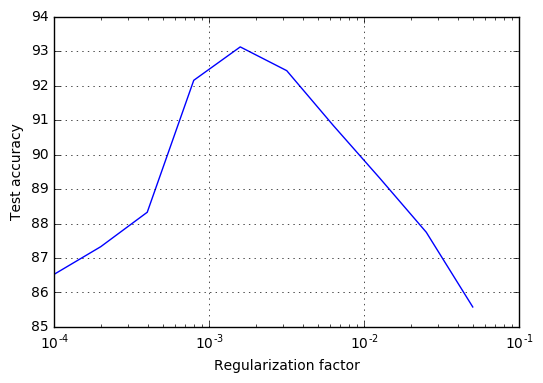

In [73]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(regularization,test_accuracies)
plt.xscale('log', linthreshx=0.001)
plt.ylabel('Test accuracy')
plt.xlabel('Regularization factor')
plt.grid(True)
plt.show()

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [86]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    
    # Input batches as placeholder.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size)) # 128, 784
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels)) # 128, 10
    tf_valid_dataset = tf.constant(valid_dataset) # 10000, 784
    tf_test_dataset = tf.constant(test_dataset) # 10000, 784
    regularization_factor = tf.placeholder(tf.float32)
    
    # Input variables
    W_1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes])) # 784, 1024
    b_1 = tf.Variable(tf.zeros([num_hidden_nodes])) # 1024
    
    # first layer
    h_1 = tf.nn.relu(tf.matmul(tf_train_dataset, W_1) + b_1)
    
    # Training computation
    W_2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels])) # 1024, 10
    b_2 = tf.Variable(tf.zeros([num_labels])) # 10
    logits = tf.matmul(h_1, W_2) + b_2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + regularization_factor * (tf.nn.l2_loss(W_1) + tf.nn.l2_loss(W_2))
    
    # optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions
    train_prediction = tf.nn.softmax(logits)
    valid_fw_pass_1 = tf.nn.relu(tf.matmul(tf_valid_dataset, W_1) + b_1) # First layer forward pass for validation
    valid_prediction = tf.nn.softmax(tf.matmul(valid_fw_pass_1, W_2) + b_2) # Softmax for validation
    test_fw_pass_1 = tf.nn.relu(tf.matmul(tf_test_dataset, W_1) + b_1)
    test_prediction = tf.nn.softmax(tf.matmul(test_fw_pass_1, W_2) + b_2)

Let's run the 1-layer neural network

In [87]:
num_steps = 100
num_batches = 5

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        
        # Minibatches
        #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        offset = step % num_batches
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, regularization_factor: 1e-3}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 5 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
            
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 706.594543
Minibatch accuracy: 4.7%
Validation accuracy: 25.7%
Minibatch loss at step 5: 365.632690
Minibatch accuracy: 78.9%
Validation accuracy: 60.9%
Minibatch loss at step 10: 313.352753
Minibatch accuracy: 99.2%
Validation accuracy: 66.4%
Minibatch loss at step 15: 312.446716
Minibatch accuracy: 99.2%
Validation accuracy: 66.5%
Minibatch loss at step 20: 310.175598
Minibatch accuracy: 99.2%
Validation accuracy: 66.4%
Minibatch loss at step 25: 309.246918
Minibatch accuracy: 99.2%
Validation accuracy: 66.4%
Minibatch loss at step 30: 307.033691
Minibatch accuracy: 99.2%
Validation accuracy: 66.4%
Minibatch loss at step 35: 306.084503
Minibatch accuracy: 99.2%
Validation accuracy: 66.4%
Minibatch loss at step 40: 303.926361
Minibatch accuracy: 99.2%
Validation accuracy: 66.4%
Minibatch loss at step 45: 302.958405
Minibatch accuracy: 99.2%
Validation accuracy: 66.4%
Minibatch loss at step 50: 300.852844
Minibatch accuracy: 99.2%
Validation accura

Model overfits to data. Our regularization doesn't prevent it since there are too much parameters.

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [88]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    
    # Input batches as placeholder.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size)) # 128, 784
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels)) # 128, 10
    tf_valid_dataset = tf.constant(valid_dataset) # 10000, 784
    tf_test_dataset = tf.constant(test_dataset) # 10000, 784
    regularization_factor = tf.placeholder(tf.float32)
    
    # Input variables
    W_1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes])) # 784, 1024
    b_1 = tf.Variable(tf.zeros([num_hidden_nodes])) # 1024
    
    # first layer
    h_1 = tf.nn.relu(tf.matmul(tf_train_dataset, W_1) + b_1)
    
    # Dropout
    drops = tf.nn.dropout(h_1, 0.5)
    
    # Training computation
    W_2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels])) # 1024, 10
    b_2 = tf.Variable(tf.zeros([num_labels])) # 10
    logits = tf.matmul(drops, W_2) + b_2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + regularization_factor * (tf.nn.l2_loss(W_1) + tf.nn.l2_loss(W_2))
    
    # optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions
    train_prediction = tf.nn.softmax(logits)
    valid_fw_pass_1 = tf.nn.relu(tf.matmul(tf_valid_dataset, W_1) + b_1) # First layer forward pass for validation
    valid_prediction = tf.nn.softmax(tf.matmul(valid_fw_pass_1, W_2) + b_2) # Softmax for validation
    test_fw_pass_1 = tf.nn.relu(tf.matmul(tf_test_dataset, W_1) + b_1)
    test_prediction = tf.nn.softmax(tf.matmul(test_fw_pass_1, W_2) + b_2)

Let's run it with dropout

In [89]:
num_steps = 100
num_batches = 5

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        
        # Minibatches
        #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        offset = step % num_batches
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, regularization_factor: 1e-3}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 5 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
            
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 818.350952
Minibatch accuracy: 7.0%
Validation accuracy: 28.3%
Minibatch loss at step 5: 404.356750
Minibatch accuracy: 81.2%
Validation accuracy: 67.3%
Minibatch loss at step 10: 317.715424
Minibatch accuracy: 95.3%
Validation accuracy: 68.6%
Minibatch loss at step 15: 315.401398
Minibatch accuracy: 97.7%
Validation accuracy: 68.4%
Minibatch loss at step 20: 312.675568
Minibatch accuracy: 97.7%
Validation accuracy: 68.8%
Minibatch loss at step 25: 313.574951
Minibatch accuracy: 98.4%
Validation accuracy: 68.9%
Minibatch loss at step 30: 308.363892
Minibatch accuracy: 98.4%
Validation accuracy: 69.8%
Minibatch loss at step 35: 311.374115
Minibatch accuracy: 97.7%
Validation accuracy: 69.8%
Minibatch loss at step 40: 305.048981
Minibatch accuracy: 99.2%
Validation accuracy: 69.8%
Minibatch loss at step 45: 303.569794
Minibatch accuracy: 97.7%
Validation accuracy: 69.6%
Minibatch loss at step 50: 304.900848
Minibatch accuracy: 98.4%
Validation accura

Even though training accuracy reached 100%, it improved both validation and test accuracy.

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


First let's try 1-layer-neural network with dropout and learning rate decay

In [101]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    
    # Input batches as placeholder.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size)) # 128, 784
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels)) # 128, 10
    tf_valid_dataset = tf.constant(valid_dataset) # 10000, 784
    tf_test_dataset = tf.constant(test_dataset) # 10000, 784
    regularization_factor = tf.placeholder(tf.float32)
    global_step = tf.Variable(0) # count the number of steps taken.
    
    
    # Input variables
    W_1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes])) # 784, 1024
    b_1 = tf.Variable(tf.zeros([num_hidden_nodes])) # 1024
    
    # first layer
    h_1 = tf.nn.relu(tf.matmul(tf_train_dataset, W_1) + b_1)
    
    # Dropout
    drops = tf.nn.dropout(h_1, 0.5)
    
    # Training computation
    W_2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels])) # 1024, 10
    b_2 = tf.Variable(tf.zeros([num_labels])) # 10
    logits = tf.matmul(drops, W_2) + b_2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + regularization_factor * (tf.nn.l2_loss(W_1) + tf.nn.l2_loss(W_2))
    
    # optimizer
    learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    # Predictions
    train_prediction = tf.nn.softmax(logits)
    valid_fw_pass_1 = tf.nn.relu(tf.matmul(tf_valid_dataset, W_1) + b_1) # First layer forward pass for validation
    valid_prediction = tf.nn.softmax(tf.matmul(valid_fw_pass_1, W_2) + b_2) # Softmax for validation
    test_fw_pass_1 = tf.nn.relu(tf.matmul(tf_test_dataset, W_1) + b_1)
    test_prediction = tf.nn.softmax(tf.matmul(test_fw_pass_1, W_2) + b_2)

Let's run it:

In [102]:
num_steps = 8001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        
        # Minibatches
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, regularization_factor: 1e-3}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
            
        if (step % 1000 == 0):
            print("Learning rate: %f" % learning_rate.eval())
            
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 765.117676
Minibatch accuracy: 17.2%
Validation accuracy: 35.6%
Learning rate: 0.500000
Minibatch loss at step 500: 203.714859
Minibatch accuracy: 72.7%
Validation accuracy: 81.6%
Minibatch loss at step 1000: 123.893089
Minibatch accuracy: 71.1%
Validation accuracy: 81.5%
Learning rate: 0.325000
Minibatch loss at step 1500: 82.833557
Minibatch accuracy: 77.3%
Validation accuracy: 82.5%
Minibatch loss at step 2000: 59.883415
Minibatch accuracy: 81.2%
Validation accuracy: 84.1%
Learning rate: 0.211250
Minibatch loss at step 2500: 47.838337
Minibatch accuracy: 82.8%
Validation accuracy: 84.8%
Minibatch loss at step 3000: 39.094994
Minibatch accuracy: 83.6%
Validation accuracy: 85.2%
Learning rate: 0.137312
Minibatch loss at step 3500: 33.639233
Minibatch accuracy: 82.0%
Validation accuracy: 85.9%
Minibatch loss at step 4000: 29.478727
Minibatch accuracy: 85.2%
Validation accuracy: 86.2%
Learning rate: 0.089253
Minibatch loss at step 4500: 27.021006
Mi

Now, let's train 2-layer neural network with dropout and learning rate decay

In [129]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    
    # Input batches as placeholder.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size)) # 128, 784
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels)) # 128, 10
    tf_valid_dataset = tf.constant(valid_dataset) # 10000, 784
    tf_test_dataset = tf.constant(test_dataset) # 10000, 784
    regularization_factor = tf.placeholder(tf.float32)
    global_step = tf.Variable(0) # count the number of steps taken.
    
    
    # Input variables
    W_1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes])) # 784, 1024
    b_1 = tf.Variable(tf.zeros([num_hidden_nodes])) # 1024
    
    # first layer
    h_1 = tf.nn.relu(tf.matmul(tf_train_dataset, W_1) + b_1)
    
    # first dropout
    drops_1 = tf.nn.dropout(h_1, 0.5)
    
    # Second layer variables
    W_2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_hidden_nodes])) # 1024, 1024
    b_2 = tf.Variable(tf.zeros([num_hidden_nodes])) # 1024
    
    # Second layer
    h_2 = tf.nn.relu(tf.matmul(h_1, W_2) + b_2)
    
    # Second dropout
    drops_2 = tf.nn.dropout(h_2, 0.5)
    
    # Training computation
    W_3 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels])) # 1024, 10
    b_3 = tf.Variable(tf.zeros([num_labels])) # 10
    logits = tf.matmul(h_2, W_3) + b_3
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + regularization_factor * (tf.nn.l2_loss(W_1) + tf.nn.l2_loss(W_2) + tf.nn.l2_loss(W_3))
    
    # optimizer
    learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    # Predictions
    train_prediction = tf.nn.softmax(logits)
    valid_fw_pass_1 = tf.nn.relu(tf.matmul(tf_valid_dataset, W_1) + b_1) # First layer forward pass for validation
    valid_fw_pass_2 = tf.nn.relu(tf.matmul(valid_fw_pass_1, W_2) + b_2) # First layer forward pass for validation
    valid_prediction = tf.nn.softmax(tf.matmul(valid_fw_pass_2, W_3) + b_3) # Softmax for validation
    test_fw_pass_1 = tf.nn.relu(tf.matmul(tf_test_dataset, W_1) + b_1)
    test_fw_pass_2 = tf.nn.relu(tf.matmul(test_fw_pass_1, W_2) + b_2)
    test_prediction = tf.nn.softmax(tf.matmul(test_fw_pass_2, W_3) + b_3)

Let's run it

In [175]:
num_steps = 4
w_init = []
w_trained = []
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    w_init.append(W_1.eval().flatten())
    w_init.append(W_2.eval().flatten())
    w_init.append(W_3.eval().flatten())
    for step in range(num_steps):
        
        # Minibatches
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, regularization_factor: 1e-3}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        print("Minibatch loss at step %d: %f" % (step, l))
        print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
        print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
            
            
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    
    w_trained.append(W_1.eval().flatten())
    w_trained.append(W_2.eval().flatten())
    w_trained.append(W_3.eval().flatten())

Initialized
Minibatch loss at step 0: 5891.055664
Minibatch accuracy: 13.3%
Validation accuracy: 14.3%
Minibatch loss at step 1: 24730298.000000
Minibatch accuracy: 16.4%
Validation accuracy: 10.0%
Minibatch loss at step 2: 89554501632.000000
Minibatch accuracy: 12.5%
Validation accuracy: 12.9%
Minibatch loss at step 3: 23330457772883968.000000
Minibatch accuracy: 7.0%
Validation accuracy: 9.1%
Test accuracy: 8.9%


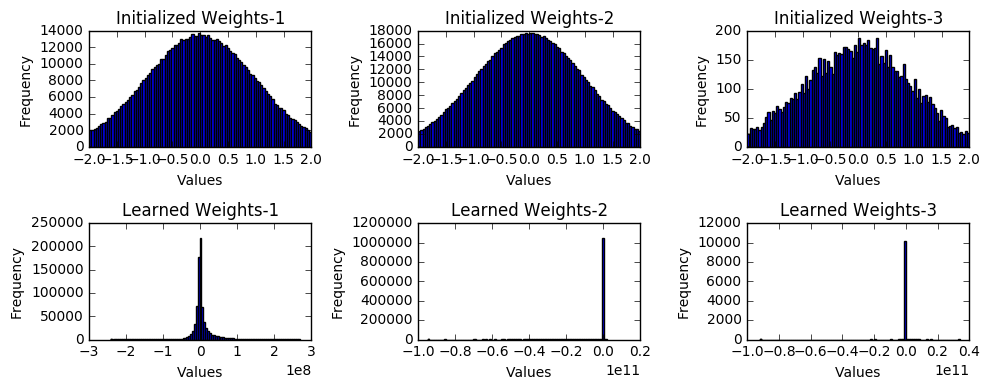

In [221]:
fig, axes = plt.subplots(2, 3, figsize=(10, 4))
axes = axes.ravel()
for idx, ax in enumerate(axes):
    if idx <= 2:
        ax.hist(w_init[idx], bins=100) 
        ax.set_title("Initialized Weights-%s" % str(idx+1))
    else:
        ax.hist(w_trained[idx-3], bins=100)
        ax.set_title("Learned Weights-%s" % str(idx-2))
    
    ax.set_xlabel("Values")
    ax.set_ylabel("Frequency")
    
fig.tight_layout()

Our weights initialization is not good enough. The problem is that the distribution of the outputs from a randomly initialized neuron has a variance that grows with the number of inputs.

A more recent paper on this topic, Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification by He et al., derives an initialization specifically for ReLU neurons, reaching the conclusion that the variance of neurons in the network should be 2.0/n. This gives the initialization w = np.random.randn(n) * sqrt(2.0/n), and is the current recommendation for use in practice in the specific case of neural networks with ReLU neurons.

Let's change it:

In [224]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    
    # Input batches as placeholder.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size)) # 128, 784
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels)) # 128, 10
    tf_valid_dataset = tf.constant(valid_dataset) # 10000, 784
    tf_test_dataset = tf.constant(test_dataset) # 10000, 784
    regularization_factor = tf.placeholder(tf.float32)
    global_step = tf.Variable(0) # count the number of steps taken.
    
    
    # Input variables
    W_1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes], stddev=np.sqrt(2.0 / (image_size * image_size)))) # 784, 1024
    b_1 = tf.Variable(tf.zeros([num_hidden_nodes])) # 1024
    
    # first layer
    h_1 = tf.nn.relu(tf.matmul(tf_train_dataset, W_1) + b_1)
    
    # first dropout
    drops_1 = tf.nn.dropout(h_1, 0.5)
    
    # Second layer variables
    W_2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_hidden_nodes], stddev=np.sqrt(2.0 / num_hidden_nodes))) # 1024, 1024
    b_2 = tf.Variable(tf.zeros([num_hidden_nodes])) # 1024
    
    # Second layer
    h_2 = tf.nn.relu(tf.matmul(h_1, W_2) + b_2)
    
    # Second dropout
    drops_2 = tf.nn.dropout(h_2, 0.5)
    
    # Training computation
    W_3 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels], stddev=np.sqrt(2.0 / num_hidden_nodes))) # 1024, 10
    b_3 = tf.Variable(tf.zeros([num_labels])) # 10
    logits = tf.matmul(h_2, W_3) + b_3
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + regularization_factor * (tf.nn.l2_loss(W_1) + tf.nn.l2_loss(W_2) + tf.nn.l2_loss(W_3))
    
    # optimizer
    learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    # Predictions
    train_prediction = tf.nn.softmax(logits)
    valid_fw_pass_1 = tf.nn.relu(tf.matmul(tf_valid_dataset, W_1) + b_1) # First layer forward pass for validation
    valid_fw_pass_2 = tf.nn.relu(tf.matmul(valid_fw_pass_1, W_2) + b_2) # First layer forward pass for validation
    valid_prediction = tf.nn.softmax(tf.matmul(valid_fw_pass_2, W_3) + b_3) # Softmax for validation
    test_fw_pass_1 = tf.nn.relu(tf.matmul(tf_test_dataset, W_1) + b_1)
    test_fw_pass_2 = tf.nn.relu(tf.matmul(test_fw_pass_1, W_2) + b_2)
    test_prediction = tf.nn.softmax(tf.matmul(test_fw_pass_2, W_3) + b_3)

Let's run it:

In [226]:
num_steps = 8001
w_init = []
w_trained = []
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    w_init.append(W_1.eval().flatten())
    w_init.append(W_2.eval().flatten())
    w_init.append(W_3.eval().flatten())
    for step in range(num_steps):
        
        # Minibatches
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, regularization_factor: 1e-3}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
            
        if (step % 1000 == 0):
            print("Learning rate: %f" % learning_rate.eval())
            
            
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    
    w_trained.append(W_1.eval().flatten())
    w_trained.append(W_2.eval().flatten())
    w_trained.append(W_3.eval().flatten())

Initialized
Minibatch loss at step 0: 4.020315
Minibatch accuracy: 6.2%
Validation accuracy: 41.1%
Learning rate: 0.500000
Minibatch loss at step 500: 1.464276
Minibatch accuracy: 87.5%
Validation accuracy: 85.9%
Minibatch loss at step 1000: 1.153507
Minibatch accuracy: 82.0%
Validation accuracy: 87.6%
Learning rate: 0.325000
Minibatch loss at step 1500: 0.833157
Minibatch accuracy: 92.2%
Validation accuracy: 88.4%
Minibatch loss at step 2000: 0.746098
Minibatch accuracy: 89.1%
Validation accuracy: 89.0%
Learning rate: 0.211250
Minibatch loss at step 2500: 0.679831
Minibatch accuracy: 88.3%
Validation accuracy: 89.3%
Minibatch loss at step 3000: 0.620651
Minibatch accuracy: 91.4%
Validation accuracy: 89.8%
Learning rate: 0.137312
Minibatch loss at step 3500: 0.512929
Minibatch accuracy: 93.8%
Validation accuracy: 89.7%
Minibatch loss at step 4000: 0.627701
Minibatch accuracy: 87.5%
Validation accuracy: 89.8%
Learning rate: 0.089253
Minibatch loss at step 4500: 0.565089
Minibatch accura

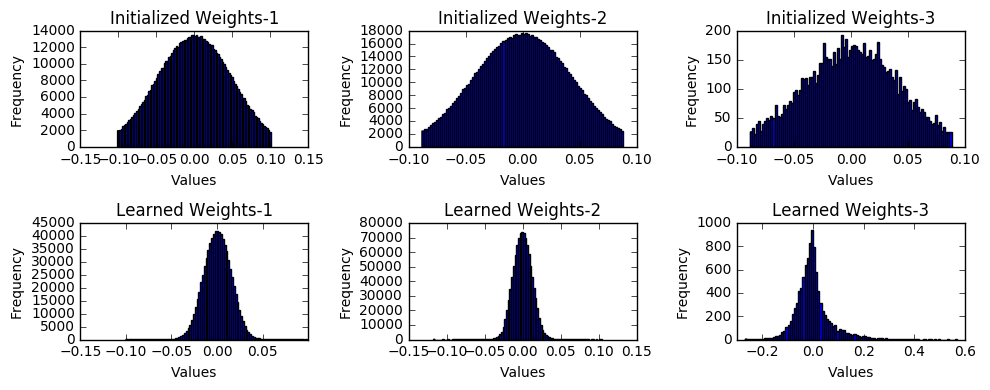

In [227]:
fig, axes = plt.subplots(2, 3, figsize=(10, 4))
axes = axes.ravel()
for idx, ax in enumerate(axes):
    if idx <= 2:
        ax.hist(w_init[idx], bins=100) 
        ax.set_title("Initialized Weights-%s" % str(idx+1))
    else:
        ax.hist(w_trained[idx-3], bins=100)
        ax.set_title("Learned Weights-%s" % str(idx-2))
    
    ax.set_xlabel("Values")
    ax.set_ylabel("Frequency")
    
fig.tight_layout()

Perfect!